In [4]:
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import ipyleaflet 
# import dtv_backend.fis
import opentnsim.strategy
import opentnsim.energy

In [2]:
# Go to the Digital Twin Vaarwegen website and click together a scenario. Export the scenario.

In [3]:
# # Load the config file with all the settings
# with open('../tests/data/ect-bctn.json') as f:
#     config = json.load(f)
    

In [11]:
# Load the config file with all the settings
with open('Mainz2Cologne.geojson') as f:
    config = json.load(f)

In [12]:
# Show the list of settings in the config file
config.keys()

dict_keys(['route', 'waypoints', 'sites', 'fleet', 'operator', 'climate', 'quantities', 'options'])

In [13]:
# Load the waypoints
waypoints_gdf = gpd.GeoDataFrame.from_features(config['waypoints'])
route_gdf = gpd.GeoDataFrame.from_features(config['route'])
fleet_gdf = gpd.GeoDataFrame.from_features(config['fleet'])
sites_gdf = gpd.GeoDataFrame.from_features(config['sites'])
bathymetry_gdf = gpd.GeoDataFrame.from_features(config['quantities']['bathymetry'])
velocities_gdf = gpd.GeoDataFrame.from_features(config['quantities']['velocities'])
waterlevel_gdf = gpd.GeoDataFrame.from_features(config['quantities']['waterlevels'])

In [19]:
velocities_gdf

,geometry,lat_p5,lat_p50,lat_p95,length_m,nap_p5,nap_p50,nap_p95,source,target,velocity,waterlevel
0,"LINESTRING (5.75612 52.57363, 5.75609 52.57429...",None,None,None,590.576576,NaN,NaN,NaN,8864726,8861055,0.29,NaN
1,"LINESTRING (5.75786 52.57861, 5.75789 52.57872...",None,None,None,22.017411,NaN,NaN,NaN,8861055,B55783_A,0.29,NaN
2,"LINESTRING (5.81917 51.84484, 5.82514 51.85149)",None,None,None,988.927530,NaN,NaN,NaN,8863811,8867825,1.06,6.898596
3,"LINESTRING (5.65621 51.96057, 5.65844 51.96166)",None,None,None,274.912552,NaN,NaN,NaN,8867976,8863993,0.44,6.061598
4,"LINESTRING (5.64924 51.95415, 5.64967 51.95548...",None,None,None,1081.974820,1.461811,1.589438,1.826923,8867976,8868222,0.44,6.061598
...,...,...,...,...,...,...,...,...,...,...,...,...
525,"LINESTRING (5.22515 51.81664, 5.22378 51.81631)",None,None,None,155.974627,-14.558473,-14.142607,-13.786260,Berth300,Berth301,1.01,1.962397
526,"LINESTRING (5.22378 51.81631, 5.22242 51.81599)",None,None,None,153.638585,-15.261757,-14.721581,-14.247894,Berth301,Berth302,1.01,1.962397
527,"LINESTRING (5.22242 51.81599, 5.22108 51.81567)",None,None,None,152.821400,-15.326326,-15.294893,-15.257273,Berth302,Berth303,1.01,1.962397
528,"LINESTRING (5.22108 51.81567, 5.21902 51.81518)",None,None,None,234.095871,-15.266959,-11.524971,-3.204976,Berth303,8865499,1.01,1.962397


<AxesSubplot:>

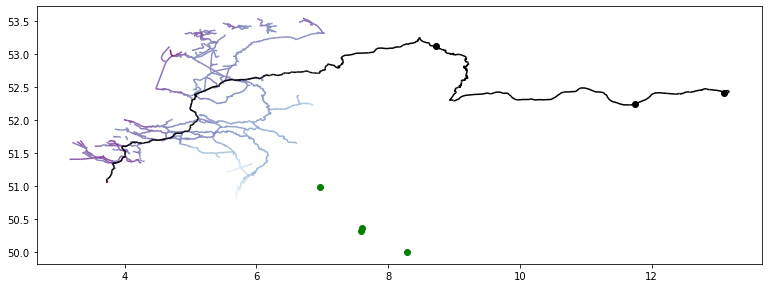

In [15]:
fig, ax = plt.subplots(figsize=(13, 8))
bathymetry_gdf.plot('nap_p50', cmap='BuPu_r', ax=ax)
route_gdf.plot(ax=ax, color='black')
waypoints_gdf.plot(ax=ax, color='green')
fleet_gdf.plot(ax=ax, color='red')

In [7]:
# take the center of the route
center_geometry = route_gdf.dissolve().centroid.iloc[0]
# lon/lat - lat/lon 
center = (center_geometry.y, center_geometry.x)

# add map
m = ipyleaflet.Map(center=center, zoom=8)

# add the layers
route_geo_data = ipyleaflet.GeoData(geo_dataframe = route_gdf, name = 'route')
m.add_layer(route_geo_data)
fleet_geo_data = ipyleaflet.GeoData(geo_dataframe = fleet_gdf, name = 'fleet', style={'color': 'red'})
m.add_layer(fleet_geo_data)

# show the map
m

Map(center=[51.87005200395497, 4.923271114583653], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [22]:
def compute_draught_load_fraction(vessel_row):
    level = 280
    capacity = 400
    filling_degree = level / capacity
    T_f = vessel_row['Draught loaded [m]']
    T_e = vessel_row['Draught empty [m]']
    T_range = T_f - T_e
    T = (T_range * filling_degree) + T_e
    return T

def create_vessel(vessel_row, **kwargs):
    model_input = {
        'L': vessel_row['Length [m]'],
        'B': vessel_row['Beam [m]'],
        'type': vessel_row['RWS-class'],
        'P_installed': float(vessel_row['Engine power maximum [kW]']),
        'L_w': 3,
        'C_year': 2000,
        'P_hotel_perc': 0.05
    }
    model_input.update(**kwargs)

    Vessel = type('Vessel', (opentnsim.core.VesselProperties, opentnsim.energy.ConsumesEnergy), {})
    vessel = Vessel(**model_input)
    return vessel

def compute_draught_dorsser(vessel_row):
    vessel = create_vessel(vessel_row)
    payload_strategy = vessel_row['Load Weight average [ton]']
    
    T = opentnsim.strategy.Payload2T(vessel=vessel, Payload_strategy=payload_strategy, vessel_type='Container')
    return T

    

In [23]:
vessel_row = fleet_gdf.iloc[0]
print('load fraction method', compute_draught_load_fraction(vessel_row))
print('dorsser method', compute_draught_dorsser(vessel_row))

# Notebook 12.


load fraction method 2.87
dorsser method 3.306212117667675


In [34]:
T = compute_draught_load_fraction(vessel_row)
vessel = create_vessel(vessel_row, T=T, P_tot_given=1800)

In [35]:
edge = {'Info': {'GeneralDepth': 3}}
opentnsim.energy.power2v(vessel, edge, upperbound=10)

3.8649135275738544

In [12]:
{
  "ship_specification": {
    "length": 135,
    "width": 11.4,
    "design_draught": 3.5
  },
  "ship_loadcase": {
    "draught": 2.5
  },
  "ship_conditions": {
    "water_depth": 10,
    "speed": [
      1,
      3,
      5,
      7
    ]
  }
}

{'ship_specification': {'length': 135, 'width': 11.4, 'design_draught': 3.5},
 'ship_loadcase': {'draught': 2.5},
 'ship_conditions': {'water_depth': 10, 'speed': [1, 3, 5, 7]}}